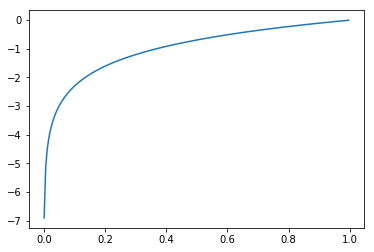

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
y_hat_t = np.arange(0.001, 1.0, 0.005)
loss = np.log(y_hat_t)
plt.plot(y_hat_t, loss)
plt.show()

## Introduction

Word2vec is a model that maps words from a vocabulary to vectors that have typically 100 to 300 dimensions.

Model training takes as input a large document collection and assigns each unique word a corresponding vector.

The model training is **unsupervised**.

Words that appear in similar contexts in the document collection have vectors that are located in close distance to each other.

It can be shown that word vectors actually encode word meanings and relations between them.

The interesting idea of the word2vec algorithm is that it generates the word vectors as a by-product of solving a **classification problem**.

A word2vec model takes fix-sized subsequences of words from the document collection and predicts the center word. 

The model internally represents every word as a word vector and the training process modifies the vectors so that they encode word semantic. 


## Optimization objective

We need a **vocabulary** that maps every word to a word ID $w_i$.

The model is trained on a sequence of training word IDs $\{w_1,w_2,...,w_T\}$ from the collection of documents.

Given a **word context** $[w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k}]$ of size $2k$, the model predicts the center word $w_t$. 

This is a **classification problem** where the examples are the word contexts and the classes are the words in the vocabulary.

More specifically, given a context, the model outputs a conditional probability distribution over all words $w_i$ in the vocabulary to be the center word $w_t$:

$$P(w_i=w_t \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k})$$


The optimization objective is to **maximize** the average probability over all examples:

$$
\frac{1}{T} \sum^{T-k}_{t=k} P(w_t \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k})
$$

Note that we are only interested in the predicted probabilities of the true center word (this is a hint for cross entropy!).

Maximizing a probability is the same as maximizing the log of the probability. 

Therefore we can change the expression to maximize the average log probability instead of the average probability:

$$
\frac{1}{T} \sum^{T-k}_{t=k} log \ P(w_t \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k})
$$

Maximizing an expression is exactly the same as minimizing the negative of the expression.

So if we just put a minus sign in front of the expression and minimize it we can use the cross-entropy loss function with gradient descent to train the model.

The **final optimization objective** is to minimize the following expression:

$$
- \frac{1}{T} \sum^{T-k}_{t=k} log \ P(w_t \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k})
$$


## How does the model work

The model **input** is a vector $[w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k}]$ of size $2k$ that represents the context for the target value $w_t$.

Every word from a vocabulary of size $m$ is mapped to a unique vector, represented by a column in an **embedding matrix** $W$.

$W$ is initialized with small random values.

Lets define a function $h(w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k}; W)$ that takes a context as input and is parametrized by $W$. 

$h$ extracts the word vectors from $W$ and aggregates them by one of the following operations:

 * concatenate
 * average
 * sum

<img src="images/word2vec.png" height="250" width="400"/> 

Than we do the following calculation:

$$
z = U \cdot h(w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k}; W) + b 
$$

$\cdot$ is the dot product

$U$ is a weight matrix and $b$ is a bias vector.

$ z = [z_1,...,z_m]$ is a vector that has as many dimensions are we have words in the vocabulary. 

Each $z_i$ is the **unnormalized probability** that $w_i$ is the center word given the context.

We use the softmax function to normalize the probabilities:

$$
P(w_i \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k}) = \frac{e^{z_i}}{\displaystyle\sum_{j=1}^T {e^{z_j}}}
$$

Finally we use the cross-entropy loss as optimization objective:

$$
 L = - \frac{1}{T} \sum^{T-k}_{t=k} log \ P(w_t \mid w_{t-k},...,w_{t-1}, w_{t+1},...,w_{t+k})
$$

$W$, $U$ and $b$ are the trainable weights of the model. 

Note that $W$ is a trainable parameter as well, its values are modified by the optimizer.

After training has converged the columns in $W$ are the vector representations of the words in the vocabulary.

## Implementation

The implementation of the model is quite simple.

The function $h$ can be implemented by two components:

 1. An [Embedding layer](https://keras.io/layers/embeddings/) performs the lookup of the word vectors in $W$
 2. The aggregation of the word vectors is performed by a [Concatenate](https://keras.io/layers/merge/#concatenate), [Average](https://keras.io/layers/merge/#average) or [Add](https://keras.io/layers/merge/#add) layer.
 
The calculation $z = U \cdot h + b$ is performed by a [Dense](https://keras.io/layers/core/#dense) layer. 

The Dense layer will be configured with a softmax activation.

The loss will be calculated by a cross-entropy loss function.

The model will be optimized by Stochastic Gradient Descent.

After training has converged a snapshot of the model will be saved.

The final model will usually not be used for prediction because we are only interested in the word vectors.

## The result

Despite the fact that the word vectors are initialized randomly, they can eventually capture semantics as an indirect result of the prediction task.

After the training converges, words with similar meaning are mapped to a similar position in the vector space. 

For example: 
 * `powerful` and `strong` are close to each other
 * whereas `powerful` and `Paris` are more distant.

The difference between word vectors also carry meaning. 

For example, the word vectors can be used to answer analogy questions using simple vector algebra: 

"king" - "man" + "woman" = "queen"